In [162]:
#basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.mixture import GaussianMixture

#parallelization
import concurrent.futures

#torch
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader


from dataset import *

In [163]:
## Loading Metadata
df = pd.read_csv('/Users/mikelgallo/repos3/final_dl/wikiart-target_style-class_26-keepgenre_True-n_100_drop-raw.csv')
label_list = df['style_path'].unique().tolist()
label_codes = {idx:val for idx, val in enumerate(label_list)}
print(label_codes)

{0: 'Impressionism', 1: 'Expressionism', 2: 'Abstract_Expressionism', 3: 'Symbolism', 4: 'Color_Field_Painting', 5: 'Ukiyo_e', 6: 'Post_Impressionism', 7: 'High_Renaissance', 8: 'Realism', 9: 'Pop_Art', 10: 'New_Realism', 11: 'Minimalism', 12: 'Art_Nouveau_Modern', 13: 'Romanticism', 14: 'Fauvism', 15: 'Synthetic_Cubism', 16: 'Baroque', 17: 'Cubism', 18: 'Analytical_Cubism', 19: 'Pointillism', 20: 'Northern_Renaissance', 21: 'Mannerism_Late_Renaissance', 22: 'Contemporary_Realism', 23: 'Naive_Art_Primitivism', 24: 'Early_Renaissance', 25: 'Rococo'}


In [164]:
## Loader PARAMS
BATCH_SIZE=1
NUM_WORKERS=8
SHUFFLE=False

In [165]:
# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(10),
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [166]:
## Test
data_dir_train = './data_split/train/'
data_dir_test = './data_split/test/'
data_dir_val = './data_split/val/'

#Define Data Loader
train_ds = Painting_Dataset(data_dir=data_dir_train, 
                             transform=data_transforms['train'], 
                             target_transform=None) #target_transforms['train']

test_ds = Painting_Dataset(data_dir=data_dir_test, 
                             transform=data_transforms['test'], 
                             target_transform=None) #target_transforms['train']

val_ds = Painting_Dataset(data_dir=data_dir_val, 
                             transform=data_transforms['val'], 
                             target_transform=None) #target_transforms['train']



train_loader = DataLoader(train_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=SHUFFLE)

test_loader = DataLoader(test_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=SHUFFLE)

val_loader = DataLoader(val_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=SHUFFLE)

#### Checking 1 iteration from Test

In [167]:
img, label, image_name = next(iter(train_loader))

In [168]:
img.shape

torch.Size([1, 3, 224, 224])

In [169]:
label[0]

tensor(14)

In [170]:
image_name[0]

'abraham-manievich_artist-s-wife-1937.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


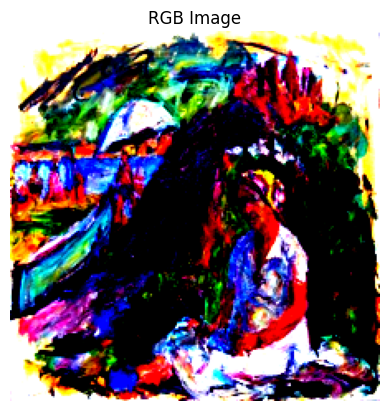

In [171]:
import matplotlib.pyplot as plt
import torch

# Assuming 'img' is the tensor obtained from the DataLoader
# img has shape [1, 3, 224, 224]
# Remove the batch dimension (1)
img = img.squeeze(0)

# Convert the tensor to numpy
img = img.permute(1, 2, 0).cpu().numpy()

# Plot the image
plt.imshow(img)
plt.title("RGB Image")
plt.axis('off')  # Turn off axis labels
plt.show()

---

In [172]:
import shutil

def clean_directory(content):
    # Specify the content directory
    content_directory = content

    # Delete everything inside the content directory
    for filename in os.listdir(content_directory):
        file_path = os.path.join(content_directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove file or link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directory
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

# Execute cleaning
clean_directory('./data_prepped/')

In [173]:
from tqdm import tqdm
# Directories to save the processed data
train_preprocessed_dir = 'data_prepped/train_prep'
test_preprocessed_dir = 'data_prepped/test_prep'
val_preprocessed_dir = 'data_prepped/val_prep'

#Create new directories
os.makedirs(train_preprocessed_dir, exist_ok=True)
os.makedirs(test_preprocessed_dir, exist_ok=True)
os.makedirs(val_preprocessed_dir, exist_ok=True)


def save_dataset_items_together(data_loader, save_dir):
    loop = tqdm(data_loader, desc="Saving dataset items")
    
    for idx, (data, label, patch_key) in enumerate(loop):
        #if idx == 5:  # This is just for demonstration; remove or adjust as needed
            #break
            
        save_path = os.path.join(save_dir, patch_key[0] + '.npz')  # Convert patch_key to string if necessary
        
        # Save both data and label in a single file
        np.savez(save_path, data=data.numpy(), label=label.numpy())

### Preprocessing

In [174]:
save_dataset_items_together(train_loader, train_preprocessed_dir)

Saving dataset items: 100%|██████████| 2080/2080 [00:59<00:00, 35.10it/s] 


In [175]:
save_dataset_items_together(test_loader, test_preprocessed_dir)

Saving dataset items: 100%|██████████| 260/260 [00:56<00:00,  4.56it/s]


In [176]:
save_dataset_items_together(val_loader, val_preprocessed_dir)

Saving dataset items: 100%|██████████| 260/260 [00:55<00:00,  4.71it/s]


In [177]:
# Function to load data and label from a .npz file
def load_dataset_item(file_path):
    with np.load(file_path) as data:
        data_array = data['data']
        label_array = data['label']
    return data_array, label_array

# Example usage
file_path = './data_prepped/train_prep/abraham-manievich_artist-s-wife-1937.jpg.npz'
data, label = load_dataset_item(file_path)

display("Data shape:", data.shape)
display("Label:", label)

'Data shape:'

(1, 3, 224, 224)

'Label:'

array([14])

---

In [178]:
from dataset_prep import *

In [179]:
# PARAMS
BATCH_SIZE = 500
NUM_WORKERS = 8
PIN_MEMORY = False
SHUFFLE = False # preprocessed data is already shuffled
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
PATIENCE = 5
# NUM_BATCHES = 10 this one when want to break early, train just one batch etc.
LOAD_MODEL = False

In [180]:
import os

dirs_d = ['data_prepped/train_prep/',
        'data_prepped/val_prep/',
        'data_prepped/test_prep/']


for i in dirs_d:
    ds_store_file_location = i+'.DS_store'
    if os.path.isfile(ds_store_file_location):
        os.remove(ds_store_file_location)

In [181]:
train_ds = Prepped_Painting_Dataset(data_dir='data_prepped/train_prep/')
valid_ds = Prepped_Painting_Dataset(data_dir='data_prepped/val_prep/')
test_ds = Prepped_Painting_Dataset(data_dir='data_prepped/test_prep/')

train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE,
                          persistent_workers=True)


valid_loader = DataLoader(valid_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE,
                          persistent_workers=True)


test_loader = DataLoader(test_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE,
                          persistent_workers=True)

In [182]:
#Testing
patch, labels = next(iter(train_loader))

print("Image: ", patch.shape)  

print("Label: ",labels.shape)


Image:  torch.Size([500, 3, 224, 224])
Label:  torch.Size([500, 1])


In [183]:
print(len(os.listdir('./data_prepped/train_prep')))
print(len(os.listdir('./data_prepped/val_prep')))
print(len(os.listdir('./data_prepped/test_prep')))

2080
260
260


---

#### Modelling

In [204]:
# PARAMS
BATCH_SIZE = 32
NUM_WORKERS = 8
PIN_MEMORY = False
SHUFFLE = False # preprocessed data is already shuffled
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
PATIENCE = 3
# NUM_BATCHES = 10 this one when want to break early, train just one batch etc.
LOAD_MODEL = False

In [205]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class PaintingNet(nn.Module):
    def __init__(self, num_classes=26):
        super(PaintingNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout_conv = nn.Dropout2d(0.3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)  # Corrected input size
        self.dropout_fc1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.dropout_fc2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout_conv(F.relu(self.conv5(x)))
        x = self.pool(x)  # Additional pooling layer to match the output size of 7x7
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.dropout_fc1(F.relu(self.fc1(x)))  # FC1 -> ReLU -> Dropout
        x = self.dropout_fc2(F.relu(self.fc2(x)))  # FC2 -> ReLU -> Dropout
        x = self.fc3(x)  # Output layer
        return x


net = PaintingNet()

# Print the model architecture
print(net)

PaintingNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv): Dropout2d(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (dropout_fc1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout_fc2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=256, out_features=26, bias=True)
)


In [206]:
def train_fn(loader, model, optimizer, loss_fn, device):
    model.train()  # Set the model to training mode
    loop = tqdm(loader, desc="Training")

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device, dtype=torch.float32)  # Move data to the specified device
        targets = targets.squeeze(1).to(device=device, dtype=torch.long)  # Squeeze targets to correct shape

        # Forward pass
        predictions = model(data)
        loss = loss_fn(predictions, targets)

        # Backward pass
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Update tqdm loop with the current loss
        loop.set_postfix(loss=loss.item())

    return loss.item()  # Return the last loss value


def validate_fn(loader, model, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    pred_list = []  # List to store predictions
    label_list = []  # List to store true labels

    with torch.no_grad():  # Disable gradient computation
        for data, targets in loader:
            data = data.to(device=device, dtype=torch.float32)  # Move data to the specified device
            targets = targets.squeeze(1).to(device=device, dtype=torch.long)  # Squeeze targets to correct shape

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            val_loss += loss.item()

            # Convert logits to class indices
            predicted_classes = torch.argmax(predictions, dim=1)

            # Store predictions and true labels
            pred_list.extend(predicted_classes.cpu().numpy())
            label_list.extend(targets.cpu().numpy())

    avg_val_loss = val_loss / len(loader)  # Calculate the average validation loss

    return avg_val_loss  # Return the average validation loss, predictions, and true labels

In [207]:
def save_predictions_and_labels(loader, model, device="cpu"):
    pred_list = []
    label_list = []
    
    model.eval()
    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device=device, dtype=torch.float32)
        labels = labels.squeeze(1).to(device=device, dtype=torch.long)  # Squeeze labels to correct shape
        with torch.no_grad():
            preds = model(x)
            # Convert logits to class indices
            predicted_classes = torch.argmax(preds, dim=1)
        
        # Save predictions and labels as NumPy arrays
        pred_list.extend(predicted_classes.cpu().numpy())
        label_list.extend(labels.cpu().numpy())

    model.train()

    return pred_list, label_list


def save_checkpoint(state, filename="checkpoint_cnn.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])


In [208]:
from tqdm import tqdm
import matplotlib.pyplot as plt  # Ensure Matplotlib is imported correctly


def main():

    model = PaintingNet().to('cpu')

    loss_fn = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses = []
    val_losses = []
    lowest_val_loss = np.inf
    epochs_no_improvement = 0
    epochs_completed = 0

    if LOAD_MODEL:
        load_checkpoint(torch.load("checkpoint_cnn.pth.tar"), model)

    for epoch in range(NUM_EPOCHS):
        
        epochs_completed += 1
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        loss = train_fn(train_loader, model, optimizer, loss_fn, device='cpu')
        val_loss = validate_fn(valid_loader, model, loss_fn,device='cpu')
        print(f'Validation loss: {val_loss}')

        if val_loss < lowest_val_loss:
            epochs_no_improvement = 0
            lowest_val_loss = val_loss
        else:
            epochs_no_improvement += 1

        if epochs_no_improvement == PATIENCE:
            print("Early Stopping")
            epochs_completed -= 1
            break

        train_losses.append(loss)
        val_losses.append(val_loss)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

    # Plot the training loss
    plt.figure()
    plt.plot(range(1, epochs_completed + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs_completed + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    pred_list, label_list = save_predictions_and_labels(loader=test_loader, model=model)

    return model, pred_list, label_list

Epoch 1/5


Training: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it, loss=3.25]


Validation loss: 3.2583436965942383
=> Saving checkpoint
Epoch 2/5


Training: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it, loss=3.24]


Validation loss: 3.257274627685547
=> Saving checkpoint
Epoch 3/5


Training: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it, loss=3.21]


Validation loss: 3.249873399734497
=> Saving checkpoint
Epoch 4/5


Training: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it, loss=3.16]


Validation loss: 3.2388594150543213
=> Saving checkpoint
Epoch 5/5


Training: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it, loss=3.15]


Validation loss: 3.2180445194244385
=> Saving checkpoint


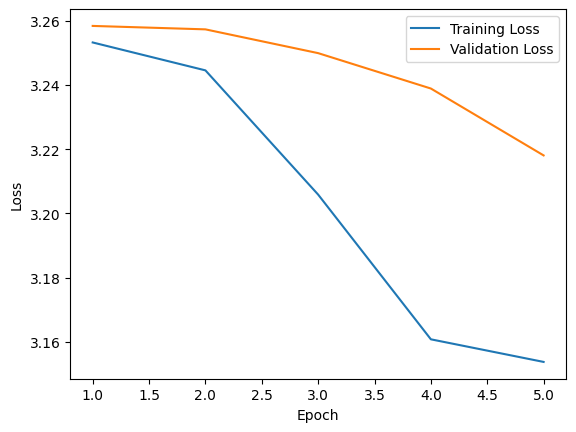

In [209]:
if __name__ == "__main__":
    model, pred_list, label_list = main()

In [210]:
print(pred_list[:25])

[10, 10, 10, 11, 25, 10, 10, 10, 11, 10, 10, 11, 10, 11, 11, 11, 25, 11, 10, 25, 25, 11, 10, 25, 10]


In [211]:
print(label_list[:25])

[12, 14, 8, 11, 21, 21, 17, 14, 14, 20, 1, 12, 9, 9, 11, 12, 24, 6, 12, 4, 16, 9, 8, 8, 0]


In [212]:
print(label_codes)

{0: 'Impressionism', 1: 'Expressionism', 2: 'Abstract_Expressionism', 3: 'Symbolism', 4: 'Color_Field_Painting', 5: 'Ukiyo_e', 6: 'Post_Impressionism', 7: 'High_Renaissance', 8: 'Realism', 9: 'Pop_Art', 10: 'New_Realism', 11: 'Minimalism', 12: 'Art_Nouveau_Modern', 13: 'Romanticism', 14: 'Fauvism', 15: 'Synthetic_Cubism', 16: 'Baroque', 17: 'Cubism', 18: 'Analytical_Cubism', 19: 'Pointillism', 20: 'Northern_Renaissance', 21: 'Mannerism_Late_Renaissance', 22: 'Contemporary_Realism', 23: 'Naive_Art_Primitivism', 24: 'Early_Renaissance', 25: 'Rococo'}


### Confusion Matrix

---

In [213]:
df[df['split']=='test'].sort_values(by='chan_image_name',ascending=True)

,image_name,split,style,style_path,genre,artist,title,chan_image_path,chan_image_name,chan_split_style,chan_split_genre,chan_split_artist
2498,art-nouveau-modern_a.y.-jackson_grey-day-laure...,test,art_nouveau_modern,Art_Nouveau_Modern,landscape,a.y.-jackson,grey-day-laurentians-1928.jpg,Art_Nouveau_Modern/a.y.-jackson_grey-day-laure...,a.y.-jackson_grey-day-laurentians-1928.jpg,train,train,NaN
2460,fauvism_abraham-manievich_camden-1923.jpg,test,fauvism,Fauvism,cityscape,abraham-manievich,camden-1923.jpg,Fauvism/abraham-manievich_camden-1923.jpg,abraham-manievich_camden-1923.jpg,val,val,NaN
2350,realism_adolf-hitler_castle-battlements.jpg,test,realism,Realism,cityscape,adolf-hitler,castle-battlements.jpg,Realism/adolf-hitler_castle-battlements.jpg,adolf-hitler_castle-battlements.jpg,train,train,NaN
2367,minimalism_agnes-martin_red-bird-1964.jpg,test,minimalism,Minimalism,abstract_painting,agnes-martin,red-bird-1964.jpg,Minimalism/agnes-martin_red-bird-1964.jpg,agnes-martin_red-bird-1964.jpg,train,train,NaN
2524,mannerism-late-renaissance_agnolo-bronzino_por...,test,mannerism_late_renaissance,Mannerism_Late_Renaissance,portrait,agnolo-bronzino,portrait-of-cosimo-i-de-medici-1.jpg,Mannerism_Late_Renaissance/agnolo-bronzino_por...,agnolo-bronzino_portrait-of-cosimo-i-de-medici...,train,train,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2353,realism_vincent-van-gogh_view-of-het-steen-188...,test,realism,Realism,cityscape,vincent-van-gogh,view-of-het-steen-1885-1.jpg,Realism/vincent-van-gogh_view-of-het-steen-188...,vincent-van-gogh_view-of-het-steen-1885-1.jpg,train,train,train
2588,rococo_william-hogarth_times-of-the-day-noon-1...,test,rococo,Rococo,genre_painting,william-hogarth,times-of-the-day-noon-1738.jpg,Rococo/william-hogarth_times-of-the-day-noon-1...,william-hogarth_times-of-the-day-noon-1738.jpg,train,train,NaN
2373,new-realism_william-james-glackens_the-shopper...,test,new_realism,New_Realism,genre_painting,william-james-glackens,the-shoppers-1907.jpg,New_Realism/william-james-glackens_the-shopper...,william-james-glackens_the-shoppers-1907.jpg,train,train,NaN
2409,impressionism_winston-churchill_view-at-mimiza...,test,impressionism,Impressionism,landscape,winston-churchill,view-at-mimizan-1920.jpg,Impressionism/winston-churchill_view-at-mimiza...,winston-churchill_view-at-mimizan-1920.jpg,train,train,NaN
